## CGANの構造
- 一番期待するのは、Generatorはどのようにy labelを自分のネットワークに込めるんだろう。
- 注意すべきこと、(x,y)のセットがDiscriminatorの入力データ。出力はreal, fakeです。
 - Supervised学習だと、xがネットワークの入力、yが出力です。

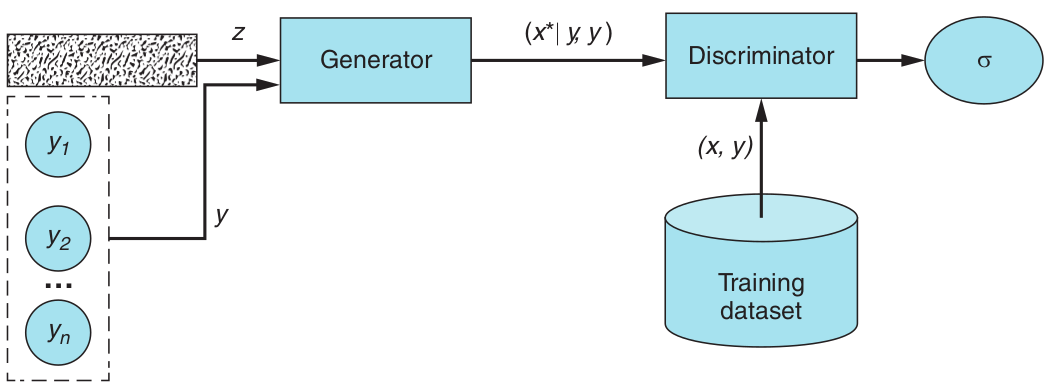

In [1]:
from IPython.display import Image
Image("img/cgan-2020-02-29 15-10-45.png")

## CGANは何をしたい？
- Generatorのアウトプットをcontrolしたい。そのcontrol情報はconditionという。
- この付け加える情報は、なんでもOK。例えば、a class label, a set of tags, or even a written description.
 - 今回の例ではclass labelを使っている。

## Generatorの２つ目標（Discriminatorの２つ目標も分かる）
- realistic-looking dataを生成する。
- 生成したデータは、y labelとmatchする。

## Generatorのy labelの使い方
- Embedding and element-wise multiplication.
 - Embedding: take label y and turn it into a dense vector of size z_dim (the length of the random noise vector).

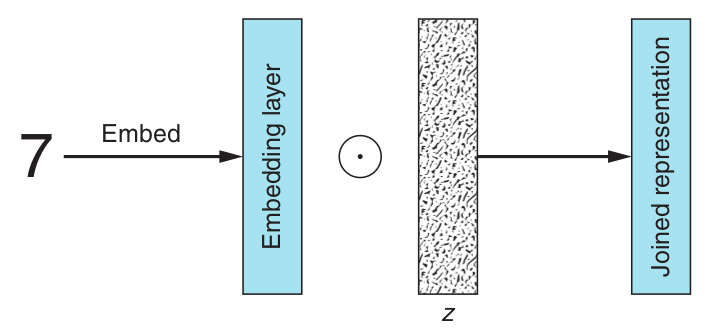

In [12]:
Image("img/cgan-combine-label-and-z-2020-02-29 18-11-34.png")

## Embeddingの例
- 参考：https://keras.io/layers/embeddings/
- 普段はword embeddingとして使われる。つまりinput_dimはoutput_dimよりだいぶ大きい。
 - one-hotでwordをencodeすると、デッカいので。
- ここで特別でinput_dimは10（数字が0~9）、output_dimは100（random noise zのサイズ）。
- 注意：
 - Embeddingの入力tensorは(batch_size, input_length)。下の例だと(4,1)。
 - the largest integer (i.e. word index) in the input should be no larger than input_dim (vocabulary size).
     - 下の例だと、vocabulary sizeはnum_classes(10)なので、labelはno larger than 9.
 - Embeddingの出力tensorは(batch_size, input_length, output_dim)。下の例だと(4,1,z_dim),(4,1,100)
 - input_lengthが必要な場合：
     - This argument is required if you are going to connect Flatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).
     - 今回はEmbeddingの次はFlattenなので、input_lengthは必要。(batch_size,1,z_dim)の真ん中の1を消すために。zのサイズ(batch_size,z_dim)に合わせるために。

In [5]:
import numpy as np
from keras.layers import Embedding
from keras.models import Sequential

In [9]:
batch_size = 4
z_dim = 100
num_classes = 10

model = Sequential()
model.add(Embedding(num_classes, z_dim, input_length=1))
# 0~9のy label batchを生成する
labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
model.compile('rmsprop', 'mse')
output_labels = model.predict(labels)
assert output_labels.shape == (batch_size, 1, z_dim)

In [10]:
print(labels) # batch_size * 1
print(output_labels) # batch_size * 1 * z_dim

[[0]
 [6]
 [4]
 [8]]
[[[ 0.03712255  0.03812785 -0.02047029 -0.04238396  0.00043427
    0.01446709  0.00417145 -0.0236241   0.0105715  -0.0157675
   -0.01773002  0.03429425 -0.0080323  -0.03029941  0.03576701
    0.02780905 -0.04113944 -0.04659129 -0.02608448 -0.03372729
    0.03495706  0.02998462 -0.04373368  0.00789087 -0.02369891
    0.00084854  0.04561322  0.04603614  0.04417323 -0.02792803
   -0.03706778 -0.03656548 -0.00275513 -0.0025066   0.00782292
    0.04856913 -0.04727573 -0.02740141 -0.01246224  0.02827007
    0.03757702  0.04512889  0.03300413  0.04745967 -0.01769105
   -0.01907235  0.03358007 -0.02738377  0.04215993  0.01847415
   -0.00312923  0.00539453  0.02994012  0.03744267 -0.00105238
    0.0205557   0.00749248  0.01454929 -0.04519347  0.01067657
    0.01522327  0.0165031   0.01173074 -0.0346277   0.04923196
    0.00426101 -0.01381166 -0.01679892 -0.04927874 -0.04975308
   -0.00548419 -0.03679546 -0.01062552 -0.04166975  0.02279992
    0.0139224   0.03296492 -0.02243

## Discriminatorのy labelの使い方
- 同じくEmbeddingでlabelを28x28x1=784に拡張する。
- 最終的に(x,y)セットは(28x28x2)のインプットになっている。
- 面白いのは、GeneratorでMultiplication、ここはConcatenateを使っている、ふふふ。

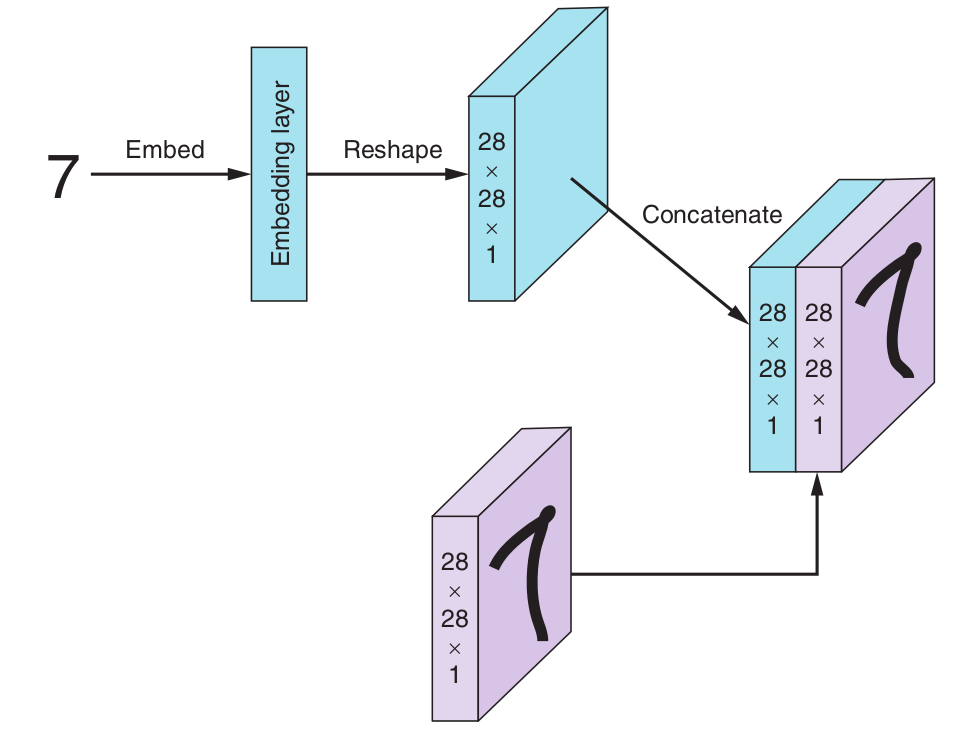

In [11]:
Image("img/cgan-combine-label-and-image-2020-02-29 19-13-20.png")

## インプットサイズの変更に合わせるDiscriminatorの変更点（DCGANと比べる）
- Discriminatorモデルのインプットサイズを(28x28x2)に変更する。
- 1つ目convolutional layerのdepthを32から64にする。なぜならインプットのdepthが2倍になっているから。情報漏れないように。

## Conditional GANの応用
- image-to-image translation.
 - translate images from one modality into another.
 - 応用例：
     - colorizing black-and-white photos.
         - 例えばinputはa black-and-white photo。labelはa colored version of the same photo.
     - turning a daytime scene into nighttime.
     - synthesizing a satellite view from a map view.
 - 最初の印象が残る実現はpix2pixですが、1年後完全にCycleGANに圧倒された。
     - Only about a year after pix2pix's publication, it was eclipsed by CycleGAN that not only outperformed pix2pix's performance on image-to-image translation tasks but also accomplised it **without the need for paired images**.
     - The Cycle-Consistent Adversarial Network needs only two groups of images representing the two domains (for example, a group of black-and-white photos and a group of colored photos.)
         - つまり２つdomainのたくさんの画像数は変わらないが、pairする必要がなくなった。そもそもpairって大変でしょう。